# Machine Learning for Data Engineers II
#### PM25 Prediction using Machine Learning

# I Introduction

Between 2016 and 2019, more than 40 000 deaths in France are probably due to the expositions to microparticles PM2.5 (particles that are around 2.5 microns). While it may be hard to know that deaths are caused by this, we know for sure how harmful they can be.

Effects due to exposure can be immediate or long-term:
- Immediate ones can include reactions such as eye or respiratory system irritation, asthma attacks and more. 
- Long-term effects (continuous exposure, which is the most common) lead to reduced life expectancy. They can also contribute to the development or aggravation of chronic diseases (cancer, neurological disorders) and others.

(https://www.ecologie.gouv.fr/pollution-lair-origines-situation-et-impacts)

PM25 are not the only air pollutants, however if we can predict the level of microparticles with simple weather data. This could be a good preventive way to be careful against high exposure and be prepared against them (wear a mask, stay at home).

While it may be difficult to measure pollutants concentrations without the rights tools, weather data is much more accessible and our project aims to have precise PM25 or other air-pollutants concentrations without any tools outside of weather data.


In [4]:
import pandas as pd 
import numpy as np 

# II Data collection and preprocessing

## Sources of data

### 1. Airparif

As a French organization, approved by the Ministry of the Environment to monitor air quality in the Île-de-France region. Airparif is an approved air quality monitoring association, it is also the reference in our region.

It provides daily forecast on the air quality directly on their website. 

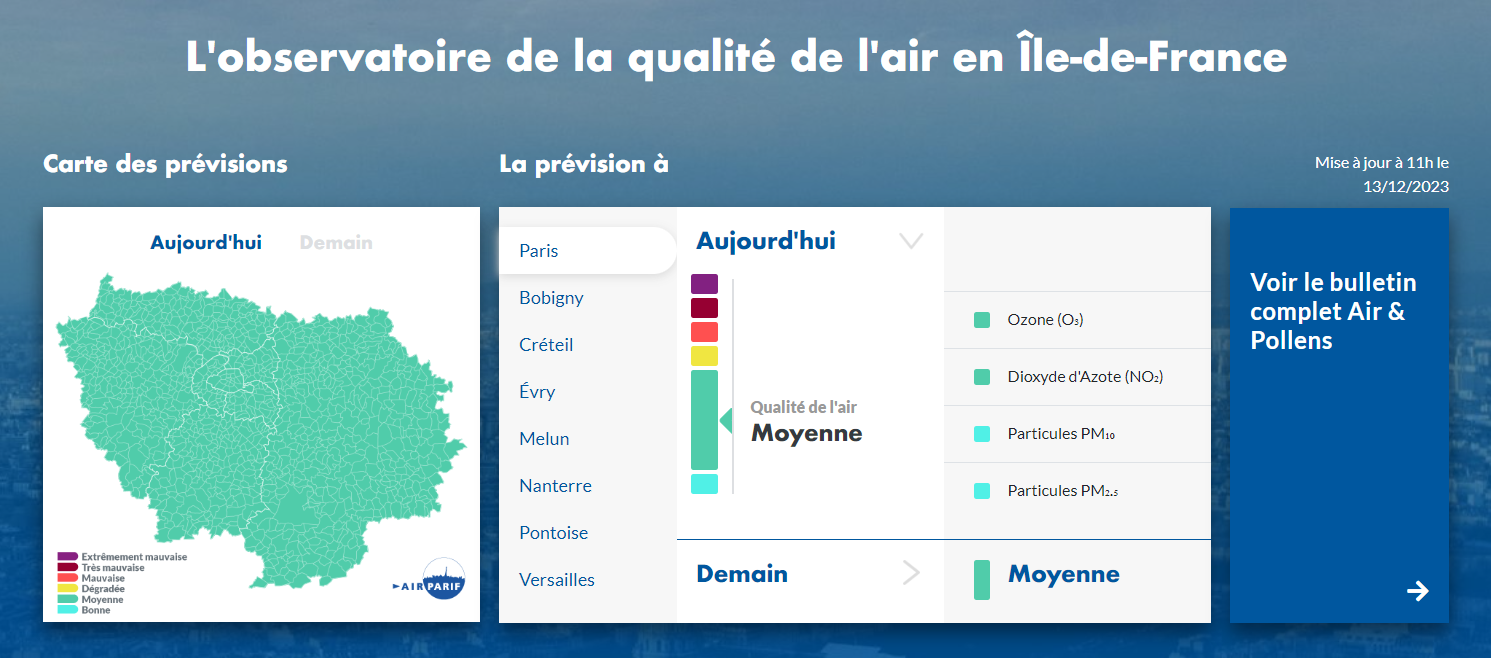

Moreover, it provides a Opendata platform that stores historical data from their observatories about air-pollutant measurements. There is also an API service to be able to fetch map data or know the air quality index prediction for tomorrow.

In our specific case, we will use their historical data from their Opendata platform (https://data-airparif-asso.opendata.arcgis.com/), they have several stations in the Île-de-France region. For this project we will focus on their Vitry station (closest to the EFREI). Each station provide hourly measurements of different pollutants.

#### 1.1 The issue with hourly air-pollutant measurements

To have accurate measurements of air pollutants, we need the right tools to do so such as Gas chromatographs. However while they may look simple... 

<img src="IMG_7278.jpg" alt="image" style="width:500px;">

They are also really expensive...

<img src="price.png" alt="image" style="width:500px;">

In our case, since we aim for air pollution prediction with weather data, it could be accessible to a broader range of people to have accurate air quality measures.

### 2. Visual Crossing Weather

It is a leading provider of historical and weather data. As a provider they possess data from almost everywhere on Earth. They provide different tools about weather data. In our case we will focus on their download platform.

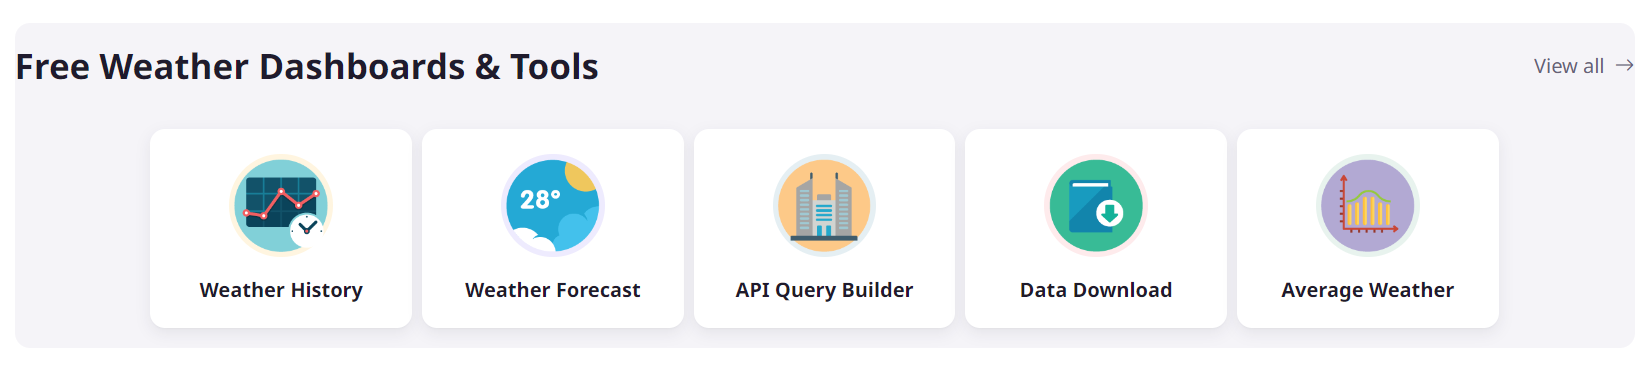

Through their download platform it is possible to fetch 1000 rows per day with an account, which was restricting for us. We managed to fetch hourly data for the whole 2022 year at Vitry.

While historical data (on a hourly basis) may be a challenge to collect, they are only useful to train our model. In real cases we would need recent data that would be more accessible to people.

## Import data
We have two different datasets, we will explore them individually them fuse them as we go deeper

In [146]:
dfp = pd.read_csv(r'2022_VITRY.csv')
dfp.head(7)

Unnamed: 0        VITRY:PM10         VITRY:PM25  \
0                     NaN   VITRY-SUR-SEINE    VITRY-SUR-SEINE   
1                     NaN             VITRY              VITRY   
2                     NaN  PM 10 particules  PM 2,5 particules   
3                     NaN              PM10               PM25   
4                     NaN         microg/m3          microg/m3   
5  2022/01/01 01:00:00+00         22.100000          19.100000   
6  2022/01/01 02:00:00+00         22.200000          19.100000   

         VITRY:NO2          VITRY:SO2          VITRY:NO        VITRY:NOX  \
0  VITRY-SUR-SEINE    VITRY-SUR-SEINE   VITRY-SUR-SEINE  VITRY-SUR-SEINE   
1            VITRY              VITRY             VITRY            VITRY   
2  dioxyde d azote  dioxyde de soufre  monoxyde d azote   oxydes d azote   
3              NO2                SO2                NO              NOX   
4        microg/m3          microg/m3         microg/m3        microg/m3   
5        23.700000           0.300000          1.800000        26.400000   
6        26.200000           0.200000          5.300000        34.300000   

          VITRY:O3  OBJECTID  
0  VITRY-SUR-SEINE         0  
1            VITRY         1  
2            ozone         2  
3               O3         3  
4        microg/m3         4  
5         7.400000         5  
6         3.500000         6

The five first columsn display different informations that are relevant to comprehend our dataset, however we do not need them. We will clean this dataset to only keep relevant data.

In [147]:
dfp = dfp.iloc[5:-1].rename(columns={"Unnamed: 0":"datetime"}).reset_index(drop=True).drop(columns=["OBJECTID"])
dfp['datetime'] = pd.to_datetime(dfp['datetime']).dt.tz_localize(None)
dfp = dfp.sort_values(by = 'datetime')
dfp['datetime'].dtype

dtype('<M8[ns]')

In [148]:
dfp

datetime VITRY:PM10 VITRY:PM25  VITRY:NO2 VITRY:SO2  VITRY:NO  \
0    2022-01-01 01:00:00  22.100000  19.100000  23.700000  0.300000  1.800000   
1    2022-01-01 02:00:00  22.200000  19.100000  26.200000  0.200000  5.300000   
2    2022-01-01 03:00:00         21  18.600000  23.100000         0  5.100000   
3    2022-01-01 04:00:00  18.900000  16.900000  19.600000         0  2.600000   
4    2022-01-01 05:00:00  18.100000  16.500000  20.100000         0         6   
...                  ...        ...        ...        ...       ...       ...   
8754 2022-12-31 19:00:00  11.200000   6.300000  13.100000       NaN         0   
8755 2022-12-31 20:00:00  11.300000   6.100000  12.200000       NaN         0   
8756 2022-12-31 21:00:00  10.100000   5.800000  11.200000       NaN         0   
8757 2022-12-31 22:00:00  10.500000   5.800000  11.300000       NaN         0   
8758 2022-12-31 23:00:00  10.700000   5.800000        NaN       NaN       NaN   

      VITRY:NOX   VITRY:O3  
0     26.400000   7.400000  
1     34.300000   3.500000  
2            31   3.400000  
3     23.600000   3.700000  
4     29.200000   2.600000  
...         ...        ...  
8754  12.400000  48.200000  
8755  11.400000  48.900000  
8756  10.200000  50.600000  
8757  10.500000  53.300000  
8758        NaN  55.600000  

[8759 rows x 8 columns]

Our second part of the dataset is the weather data from Vitry, to follow our dataset it contains all of the data from 2022 on an hourly basis.

In [149]:
import os

files = os.listdir(r'Vitry_meteo/')

dfm = pd.read_csv(r'Vitry_meteo/' + files[0]).iloc[1:]
dfm['datetime'] = pd.to_datetime(dfm['datetime'])

for file in files[1:]: 
    df = pd.read_csv(r'Vitry_meteo/' + file)
    df['datetime'] = pd.to_datetime(df['datetime'])
    dfm = pd.concat([dfm, df])

In [150]:
dfm = dfm.sort_values(by='datetime')

In [151]:
dfm['datetime'].dtype

dtype('<M8[ns]')

In [152]:
dfm.head(5)

name            datetime  temp  feelslike  dew  humidity  \
1  VITRY-SUR-SEINE 2022-01-01 01:00:00  10.3       10.3  9.6     95.05   
2  VITRY-SUR-SEINE 2022-01-01 02:00:00  10.4       10.4  9.8     96.32   
3  VITRY-SUR-SEINE 2022-01-01 03:00:00  10.1       10.1  9.4     95.87   
4  VITRY-SUR-SEINE 2022-01-01 04:00:00   9.6        8.8  9.1     96.75   
5  VITRY-SUR-SEINE 2022-01-01 05:00:00   9.2        8.3  8.7     96.84   

   precip  precipprob preciptype  snow  ...  sealevelpressure  cloudcover  \
1   0.000           0        NaN   0.0  ...            1026.4        68.2   
2   0.000           0        NaN   0.0  ...            1026.5        92.9   
3   0.000           0        NaN   0.0  ...            1026.4        49.6   
4   0.000           0        NaN   0.0  ...            1026.2        38.1   
5   0.053         100       rain   0.0  ...            1026.1        55.8   

   visibility  solarradiation  solarenergy  uvindex  severerisk  \
1         4.1             0.0          0.0      0.0         NaN   
2         5.2             0.0          0.0      0.0         NaN   
3         4.4             0.0          0.0      0.0         NaN   
4         4.1             0.0          0.0      0.0         NaN   
5         3.0             0.0          0.0      0.0         NaN   

               conditions                 icon  \
1        Partially cloudy  partly-cloudy-night   
2                Overcast               cloudy   
3        Partially cloudy  partly-cloudy-night   
4        Partially cloudy  partly-cloudy-night   
5  Rain, Partially cloudy                 rain   

                                            stations  
1  07149099999,07156099999,07146099999,0715709999...  
2  07149099999,07156099999,07146099999,0715709999...  
3  07149099999,07156099999,07146099999,0715709999...  
4  07149099999,07156099999,07146099999,0715709999...  
5  07149099999,07156099999,07146099999,0715709999...  

[5 rows x 24 columns]

Now we can proceed to a merge of our two datasets on the datetimes that are the same.

In [153]:
df = pd.merge(dfp,dfm, on='datetime')

In [154]:
df.head(5)

datetime VITRY:PM10 VITRY:PM25  VITRY:NO2 VITRY:SO2  VITRY:NO  \
0 2022-01-01 01:00:00  22.100000  19.100000  23.700000  0.300000  1.800000   
1 2022-01-01 02:00:00  22.200000  19.100000  26.200000  0.200000  5.300000   
2 2022-01-01 03:00:00         21  18.600000  23.100000         0  5.100000   
3 2022-01-01 04:00:00  18.900000  16.900000  19.600000         0  2.600000   
4 2022-01-01 05:00:00  18.100000  16.500000  20.100000         0         6   

   VITRY:NOX  VITRY:O3             name  temp  ...  sealevelpressure  \
0  26.400000  7.400000  VITRY-SUR-SEINE  10.3  ...            1026.4   
1  34.300000  3.500000  VITRY-SUR-SEINE  10.4  ...            1026.5   
2         31  3.400000  VITRY-SUR-SEINE  10.1  ...            1026.4   
3  23.600000  3.700000  VITRY-SUR-SEINE   9.6  ...            1026.2   
4  29.200000  2.600000  VITRY-SUR-SEINE   9.2  ...            1026.1   

   cloudcover  visibility  solarradiation  solarenergy uvindex  severerisk  \
0        68.2         4.1             0.0          0.0     0.0         NaN   
1        92.9         5.2             0.0          0.0     0.0         NaN   
2        49.6         4.4             0.0          0.0     0.0         NaN   
3        38.1         4.1             0.0          0.0     0.0         NaN   
4        55.8         3.0             0.0          0.0     0.0         NaN   

               conditions                 icon  \
0        Partially cloudy  partly-cloudy-night   
1                Overcast               cloudy   
2        Partially cloudy  partly-cloudy-night   
3        Partially cloudy  partly-cloudy-night   
4  Rain, Partially cloudy                 rain   

                                            stations  
0  07149099999,07156099999,07146099999,0715709999...  
1  07149099999,07156099999,07146099999,0715709999...  
2  07149099999,07156099999,07146099999,0715709999...  
3  07149099999,07156099999,07146099999,0715709999...  
4  07149099999,07156099999,07146099999,0715709999...  

[5 rows x 31 columns]

In [155]:
df.tail(5)

datetime VITRY:PM10 VITRY:PM25  VITRY:NO2 VITRY:SO2 VITRY:NO  \
8754 2022-12-31 19:00:00  11.200000   6.300000  13.100000       NaN        0   
8755 2022-12-31 20:00:00  11.300000   6.100000  12.200000       NaN        0   
8756 2022-12-31 21:00:00  10.100000   5.800000  11.200000       NaN        0   
8757 2022-12-31 22:00:00  10.500000   5.800000  11.300000       NaN        0   
8758 2022-12-31 23:00:00  10.700000   5.800000        NaN       NaN      NaN   

      VITRY:NOX   VITRY:O3             name  temp  ...  sealevelpressure  \
8754  12.400000  48.200000  vitry-sur-seine  14.8  ...            1012.5   
8755  11.400000  48.900000  vitry-sur-seine  14.6  ...            1013.2   
8756  10.200000  50.600000  vitry-sur-seine  14.4  ...            1013.4   
8757  10.500000  53.300000  vitry-sur-seine  14.4  ...            1013.4   
8758        NaN  55.600000  vitry-sur-seine  14.5  ...            1013.7   

      cloudcover  visibility  solarradiation  solarenergy uvindex  severerisk  \
8754        93.8        29.4             0.0          0.0     0.0         NaN   
8755        64.7        28.1             0.0          0.0     0.0         NaN   
8756        45.5        28.6             0.0          0.0     0.0         NaN   
8757        51.6        28.3             0.0          0.0     0.0         NaN   
8758        73.5        28.5             0.0          0.0     0.0         NaN   

            conditions                 icon  \
8754          Overcast               cloudy   
8755  Partially cloudy  partly-cloudy-night   
8756  Partially cloudy  partly-cloudy-night   
8757  Partially cloudy  partly-cloudy-night   
8758  Partially cloudy  partly-cloudy-night   

                                               stations  
8754  07149099999,07156099999,07146099999,0715709999...  
8755  07149099999,07156099999,07146099999,0715709999...  
8756  07149099999,07156099999,07146099999,0715709999...  
8757  07149099999,07156099999,07146099999,0715709999...  
8758  07149099999,07156099999,07146099999,0715709999...  

[5 rows x 31 columns]

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759 entries, 0 to 8758
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          8759 non-null   datetime64[ns]
 1   VITRY:PM10        8737 non-null   object        
 2   VITRY:PM25        8741 non-null   object        
 3   VITRY:NO2         8287 non-null   object        
 4   VITRY:SO2         633 non-null    object        
 5   VITRY:NO          8287 non-null   object        
 6   VITRY:NOX         8287 non-null   object        
 7   VITRY:O3          8598 non-null   object        
 8   name              8759 non-null   object        
 9   temp              8759 non-null   float64       
 10  feelslike         8759 non-null   float64       
 11  dew               8759 non-null   float64       
 12  humidity          8759 non-null   float64       
 13  precip            8759 non-null   float64       
 14  precipprob        8759 n

In [157]:
df.isnull().sum()

datetime               0
VITRY:PM10            22
VITRY:PM25            18
VITRY:NO2            472
VITRY:SO2           8126
VITRY:NO             472
VITRY:NOX            472
VITRY:O3             161
name                   0
temp                   0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
preciptype          7879
snow                  75
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility            46
solarradiation        46
solarenergy           46
uvindex               46
severerisk          7548
conditions             0
icon                   0
stations               0
dtype: int64

We can see that there is a great number of null values for the SO2 measurement, preciptype and severerisk.

In [158]:
df[['preciptype','severerisk']][df['preciptype'].notnull()]

preciptype  severerisk
4          rain         NaN
7          rain         NaN
8          rain         NaN
13         rain         NaN
40         rain         NaN
...         ...         ...
8732       rain         NaN
8734       rain         NaN
8735       rain         NaN
8737       rain         NaN
8742       rain         NaN

[880 rows x 2 columns]

In [159]:
df['preciptype'].unique()

array([nan, 'rain', 'rain,snow'], dtype=object)

In [160]:
df['severerisk'].unique()

array([nan, 10.])

In [161]:
df['VITRY:SO2'].unique()

array(['0.300000', '0.200000', '0', '0.100000', '0.500000', '0.400000',
       '0.900000', '1.200000', '0.700000', '0.600000', '1.400000',
       '0.800000', '1.100000', '1.300000', nan, '1', '2.100000',
       '2.300000', '3.700000', '3.800000', '4.200000', '3.900000',
       '3.400000', '3.200000', '2.800000', '3', '2.600000', '2.900000',
       '3.100000', '3.600000', '4.100000', '1.900000', '1.600000',
       '1.800000', '1.500000', '2.500000', '3.500000', '2.400000',
       '1.700000', '2.200000', '2.700000', '3.300000'], dtype=object)

In [162]:
from tabulate import tabulate

In [163]:
print(tabulate(df.head(10), headers='keys', tablefmt='psql'))

+----+---------------------+--------------+--------------+-------------+-------------+------------+-------------+------------+-----------------+--------+-------------+-------+------------+----------+--------------+--------------+--------+-------------+------------+-------------+-----------+--------------------+--------------+--------------+------------------+---------------+-----------+--------------+------------------------+---------------------+-------------------------------------------------------------------------------+
|    | datetime            |   VITRY:PM10 |   VITRY:PM25 |   VITRY:NO2 |   VITRY:SO2 |   VITRY:NO |   VITRY:NOX |   VITRY:O3 | name            |   temp |   feelslike |   dew |   humidity |   precip |   precipprob | preciptype   |   snow |   snowdepth |   windgust |   windspeed |   winddir |   sealevelpressure |   cloudcover |   visibility |   solarradiation |   solarenergy |   uvindex |   severerisk | conditions             | icon                | stations        

Going through our dataset, we can now try to remove some columns that are not relevant for our study.

We can think of name, feelslike (temperature), precipprob, severerisk, choose icon instead of conditions and remove stations

In [164]:
df = df.drop(columns=['name','feelslike','precipprob','severerisk','conditions','stations'], errors = "ignore")

In [165]:
print(tabulate(df.head(5), headers='keys', tablefmt='psql'))

+----+---------------------+--------------+--------------+-------------+-------------+------------+-------------+------------+--------+-------+------------+----------+--------------+--------+-------------+------------+-------------+-----------+--------------------+--------------+--------------+------------------+---------------+-----------+---------------------+
|    | datetime            |   VITRY:PM10 |   VITRY:PM25 |   VITRY:NO2 |   VITRY:SO2 |   VITRY:NO |   VITRY:NOX |   VITRY:O3 |   temp |   dew |   humidity |   precip | preciptype   |   snow |   snowdepth |   windgust |   windspeed |   winddir |   sealevelpressure |   cloudcover |   visibility |   solarradiation |   solarenergy |   uvindex | icon                |
|----+---------------------+--------------+--------------+-------------+-------------+------------+-------------+------------+--------+-------+------------+----------+--------------+--------+-------------+------------+-------------+-----------+--------------------+-----

In [166]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['preciptype'] = le.fit_transform(df['preciptype'])

print(dict(zip(le.classes_, le.transform(le.classes_))))

{'rain': 0, 'rain,snow': 1, nan: 2}


Now for the preciptype, we will have labels instead of rain or nans.

In [167]:
print(tabulate(df.head(5), headers='keys', tablefmt='psql'))

+----+---------------------+--------------+--------------+-------------+-------------+------------+-------------+------------+--------+-------+------------+----------+--------------+--------+-------------+------------+-------------+-----------+--------------------+--------------+--------------+------------------+---------------+-----------+---------------------+
|    | datetime            |   VITRY:PM10 |   VITRY:PM25 |   VITRY:NO2 |   VITRY:SO2 |   VITRY:NO |   VITRY:NOX |   VITRY:O3 |   temp |   dew |   humidity |   precip |   preciptype |   snow |   snowdepth |   windgust |   windspeed |   winddir |   sealevelpressure |   cloudcover |   visibility |   solarradiation |   solarenergy |   uvindex | icon                |
|----+---------------------+--------------+--------------+-------------+-------------+------------+-------------+------------+--------+-------+------------+----------+--------------+--------+-------------+------------+-------------+-----------+--------------------+-----

Depending on the data there can be several values that are null almost all of the time, let's check them and remove if needed.

In [168]:
df.dtypes

datetime            datetime64[ns]
VITRY:PM10                  object
VITRY:PM25                  object
VITRY:NO2                   object
VITRY:SO2                   object
VITRY:NO                    object
VITRY:NOX                   object
VITRY:O3                    object
temp                       float64
dew                        float64
humidity                   float64
precip                     float64
preciptype                   int32
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                    float64
icon                        object
dtype: object

One last thing would be to convert our pollutants concentrations to float64.

In [169]:
df['VITRY:PM10'] = pd.to_numeric(df['VITRY:PM10'])
df['VITRY:PM25'] = pd.to_numeric(df['VITRY:PM25'])
df['VITRY:NO2'] = pd.to_numeric(df['VITRY:NO2'])
df['VITRY:SO2'] = pd.to_numeric(df['VITRY:SO2'])
df['VITRY:NO'] = pd.to_numeric(df['VITRY:NO'])
df['VITRY:NOX'] = pd.to_numeric(df['VITRY:NOX'])
df['VITRY:O3'] = pd.to_numeric(df['VITRY:O3'])

In [170]:
df.dtypes

datetime            datetime64[ns]
VITRY:PM10                 float64
VITRY:PM25                 float64
VITRY:NO2                  float64
VITRY:SO2                  float64
VITRY:NO                   float64
VITRY:NOX                  float64
VITRY:O3                   float64
temp                       float64
dew                        float64
humidity                   float64
precip                     float64
preciptype                   int32
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                    float64
icon                        object
dtype: object

# III Exploratory Data Analysis (EDA)

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
df.describe(include='all').T

count unique     top  freq                           mean  \
datetime            8759    NaN     NaN   NaN  2022-07-02 12:35:40.518323968   
VITRY:PM10        8737.0    NaN     NaN   NaN                      16.302987   
VITRY:PM25        8741.0    NaN     NaN   NaN                      10.471811   
VITRY:NO2         8287.0    NaN     NaN   NaN                      21.001388   
VITRY:SO2          633.0    NaN     NaN   NaN                       0.595103   
VITRY:NO          8287.0    NaN     NaN   NaN                       5.454374   
VITRY:NOX         8287.0    NaN     NaN   NaN                      29.199952   
VITRY:O3          8598.0    NaN     NaN   NaN                      50.966748   
temp              8759.0    NaN     NaN   NaN                      13.722742   
dew               8759.0    NaN     NaN   NaN                       7.711348   
humidity          8759.0    NaN     NaN   NaN                      70.514705   
precip            8759.0    NaN     NaN   NaN                       0.054108   
preciptype        8759.0    NaN     NaN   NaN                       1.800662   
snow              8684.0    NaN     NaN   NaN                       0.000161   
snowdepth         8759.0    NaN     NaN   NaN                       0.001496   
windgust          8759.0    NaN     NaN   NaN                      25.447517   
windspeed         8759.0    NaN     NaN   NaN                      11.367827   
winddir           8759.0    NaN     NaN   NaN                     176.263694   
sealevelpressure  8759.0    NaN     NaN   NaN                    1018.240153   
cloudcover        8759.0    NaN     NaN   NaN                      66.739822   
visibility        8713.0    NaN     NaN   NaN                      20.545048   
solarradiation    8713.0    NaN     NaN   NaN                      62.165454   
solarenergy       8713.0    NaN     NaN   NaN                       0.223436   
uvindex           8713.0    NaN     NaN   NaN                        0.58407   
icon                8759      8  cloudy  2877                            NaN   

                                  min                  25%  \
datetime          2022-01-01 01:00:00  2022-04-02 07:30:00   
VITRY:PM10                        0.6                  9.0   
VITRY:PM25                        0.5                  4.7   
VITRY:NO2                         1.3                  9.8   
VITRY:SO2                         0.0                  0.0   
VITRY:NO                          0.0                  0.0   
VITRY:NOX                         0.1                 10.4   
VITRY:O3                          0.3                 28.7   
temp                             -5.4                  8.3   
dew                              -8.3                  4.1   
humidity                        15.83                56.16   
precip                            0.0                  0.0   
preciptype                        0.0                  2.0   
snow                              0.0                  0.0   
snowdepth                         0.0                  0.0   
windgust                          3.2                 17.3   
windspeed                         0.4                  7.5   
winddir                           1.0                 75.0   
sealevelpressure                987.2               1013.1   
cloudcover                        0.0                 39.3   
visibility                        0.0                 16.6   
solarradiation                    0.0                  0.0   
solarenergy                       0.0                  0.0   
uvindex                           0.0                  0.0   
icon                              NaN                  NaN   

                                  50%                  75%  \
datetime          2022-07-02 13:00:00  2022-10-01 18:30:00   
VITRY:PM10                       13.2                 20.7   
VITRY:PM25                        7.2                 13.1   
VITRY:NO2                        16.5                 28.5   
VITRY:SO2      

Let's split numerical and categorical variables

In [173]:
cat_cols= df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['icon'], dtype='object')
Numerical Variables:
['VITRY:PM10', 'VITRY:PM25', 'VITRY:NO2', 'VITRY:SO2', 'VITRY:NO', 'VITRY:NOX', 'VITRY:O3', 'temp', 'dew', 'humidity', 'precip', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']


VITRY:PM10
Skew : 1.96


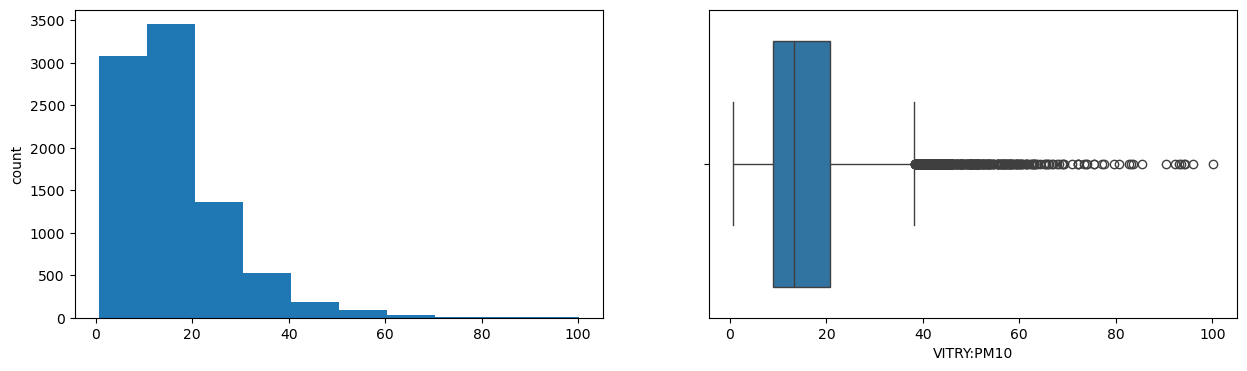

VITRY:PM25
Skew : 2.5


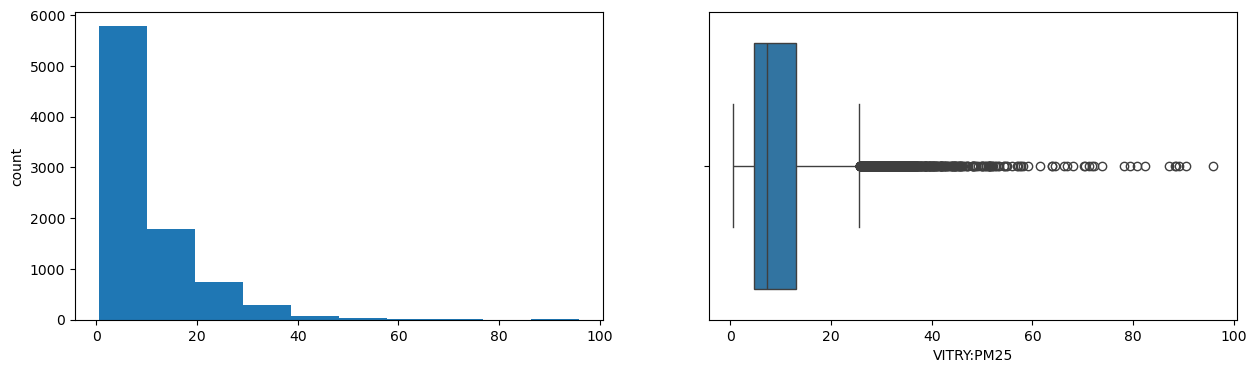

VITRY:NO2
Skew : 1.25


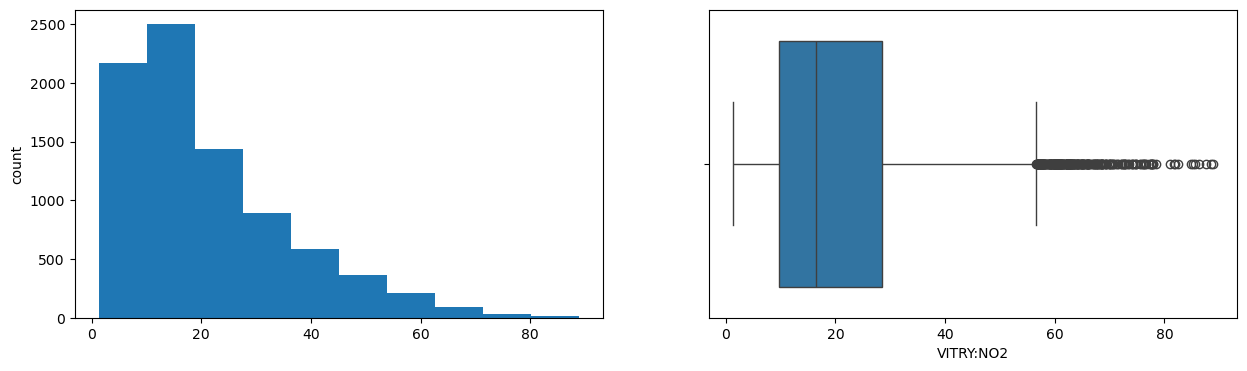

VITRY:SO2
Skew : 1.98


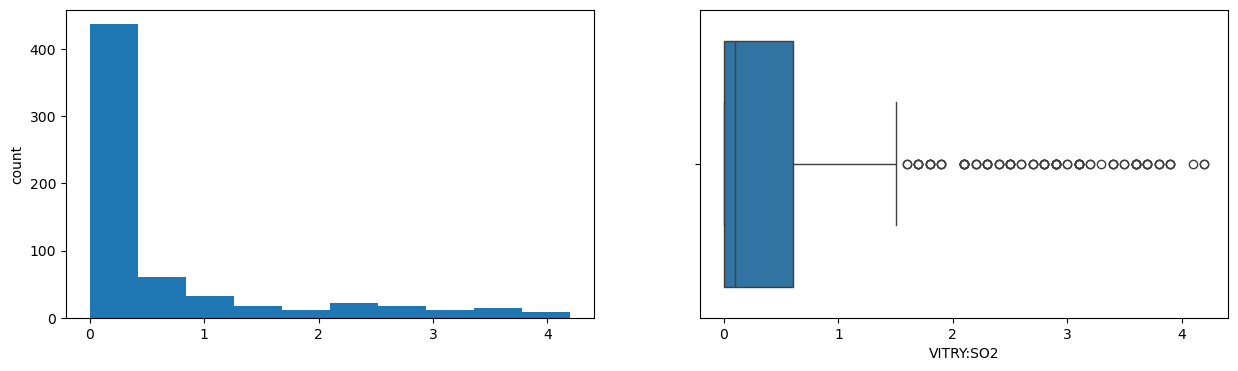

VITRY:NO
Skew : 9.06


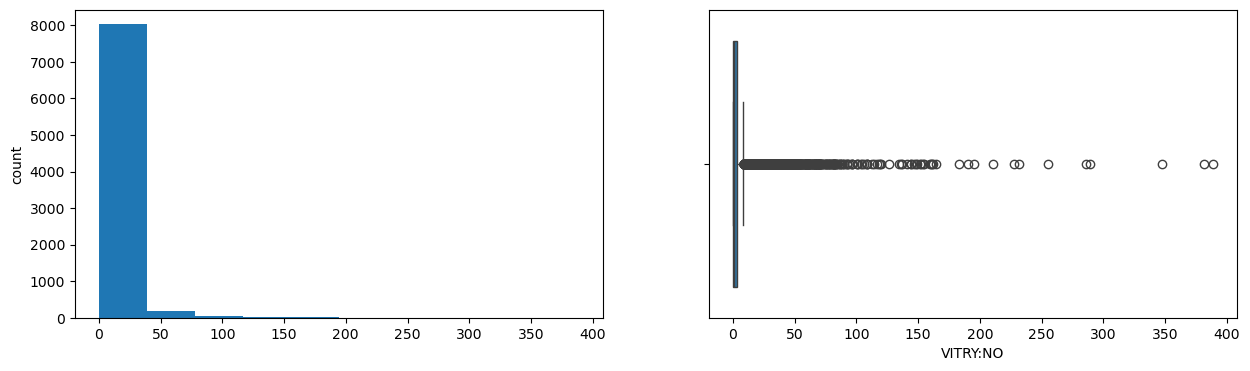

VITRY:NOX
Skew : 5.48


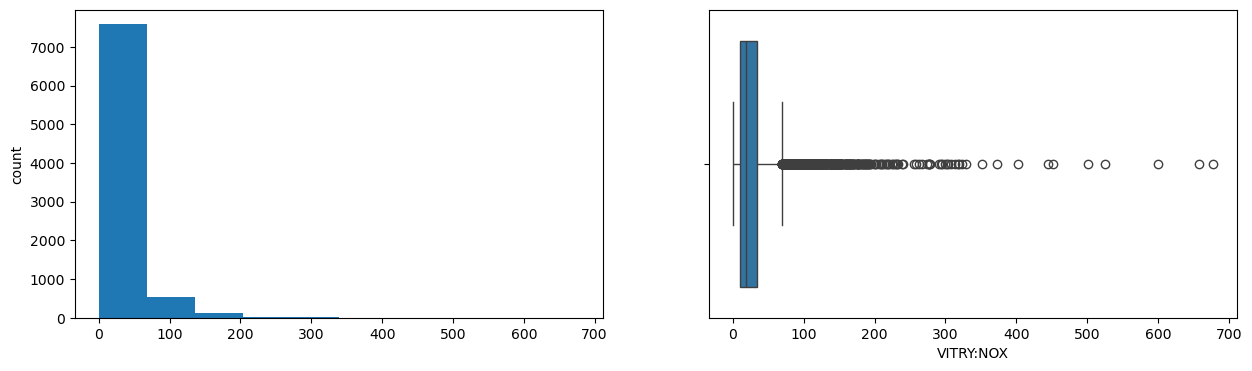

VITRY:O3
Skew : 0.36


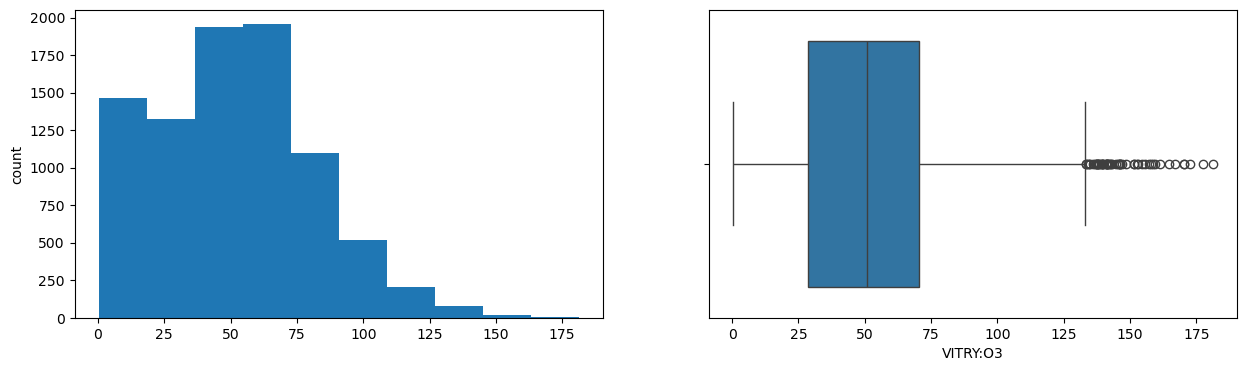

temp
Skew : 0.21


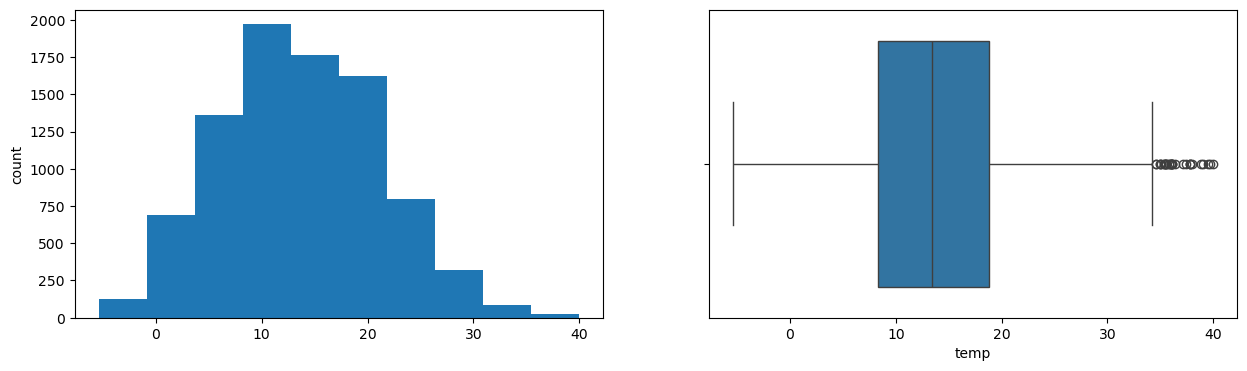

dew
Skew : -0.28


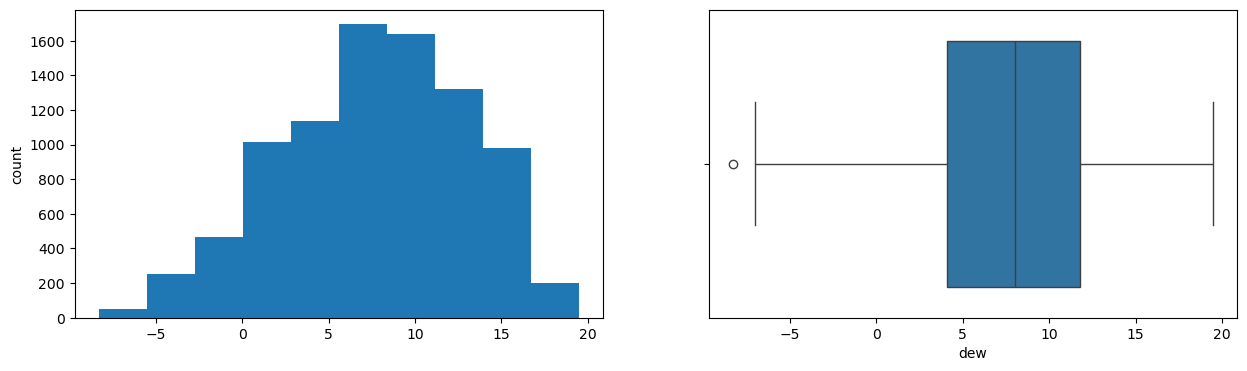

humidity
Skew : -0.54


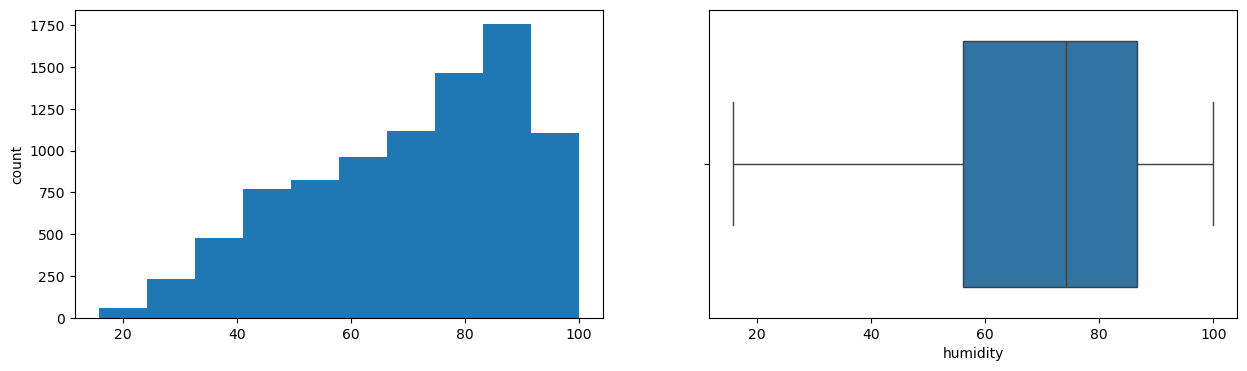

precip
Skew : 38.14


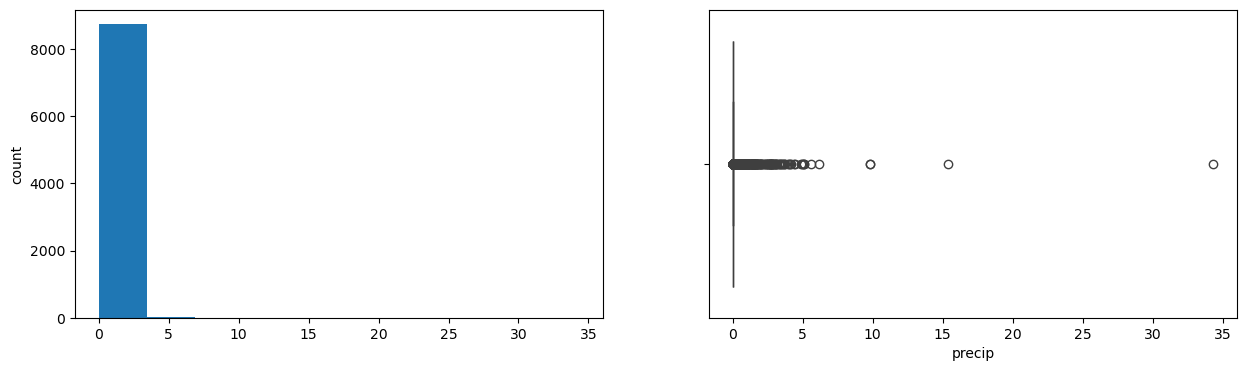

preciptype
Skew : -2.67


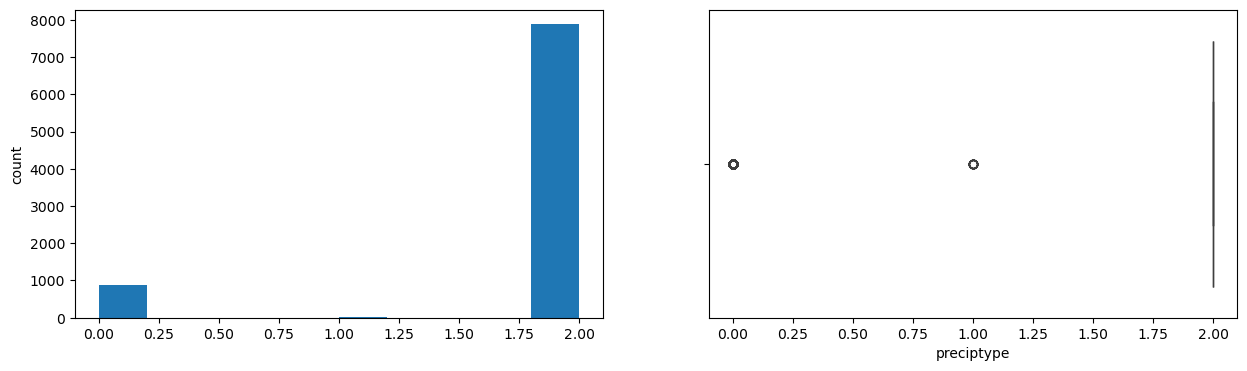

snow
Skew : 54.26


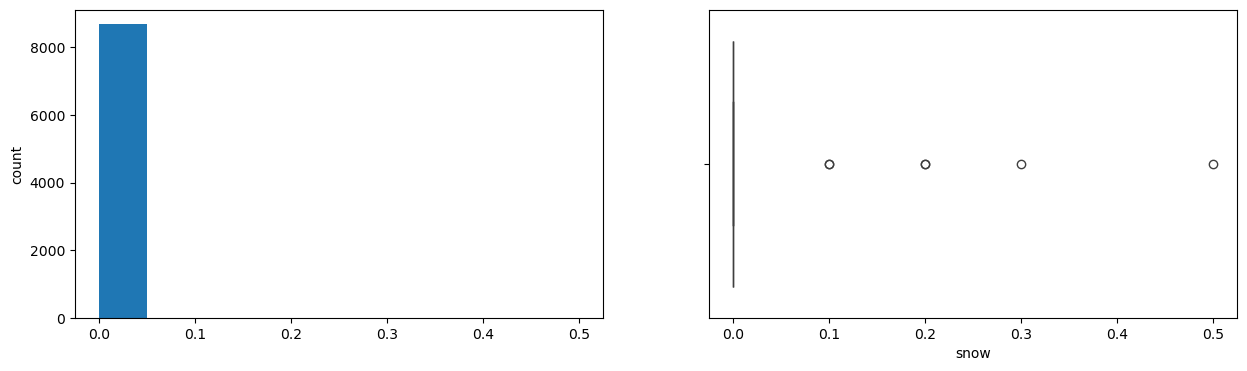

snowdepth
Skew : 40.85


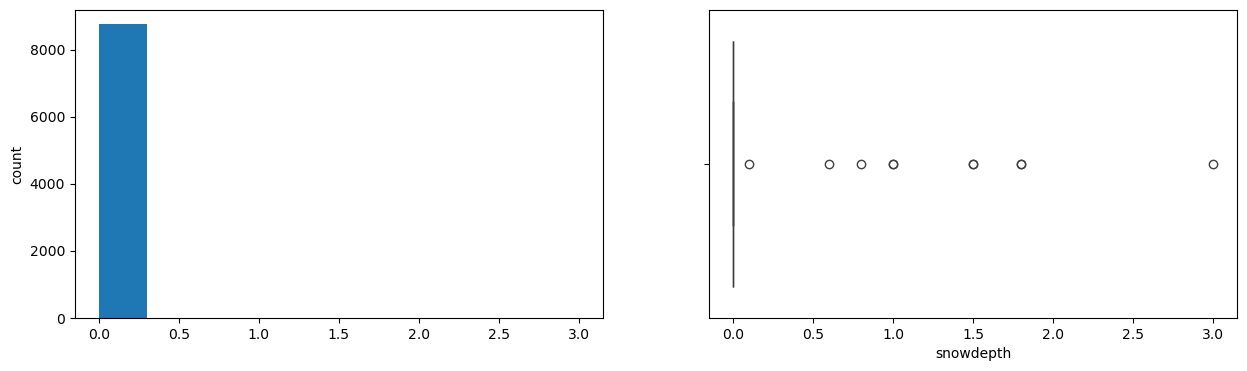

windgust
Skew : 0.84


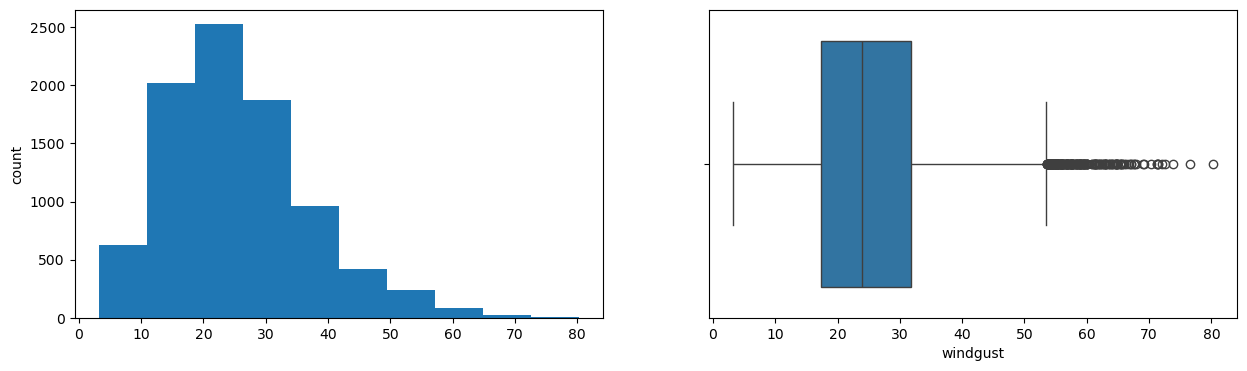

windspeed
Skew : 0.86


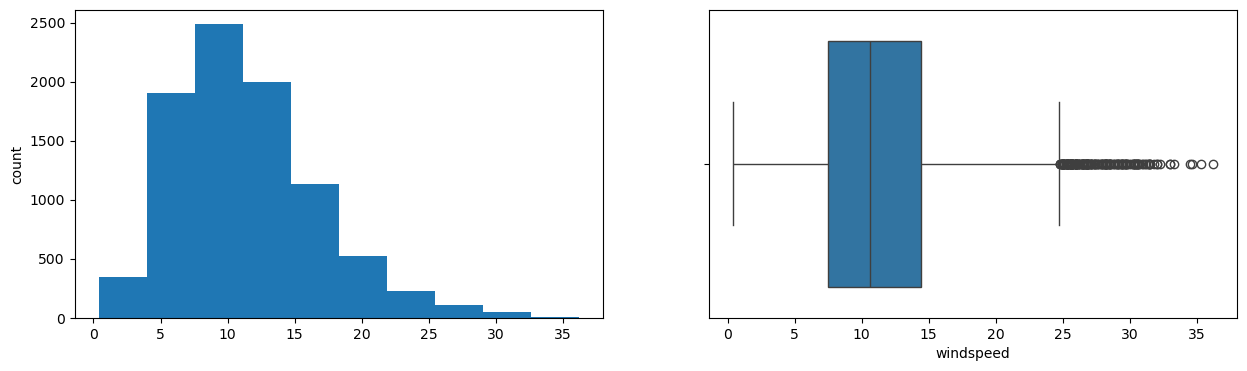

winddir
Skew : -0.08


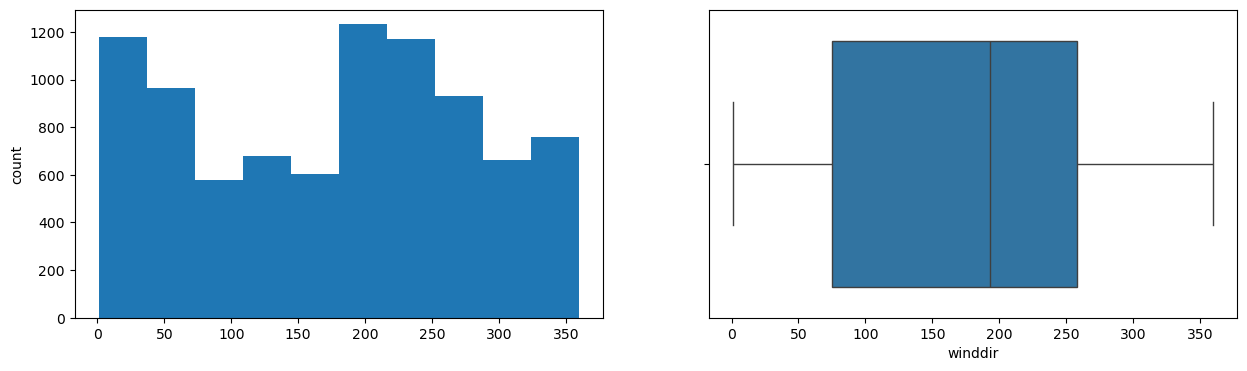

sealevelpressure
Skew : -0.07


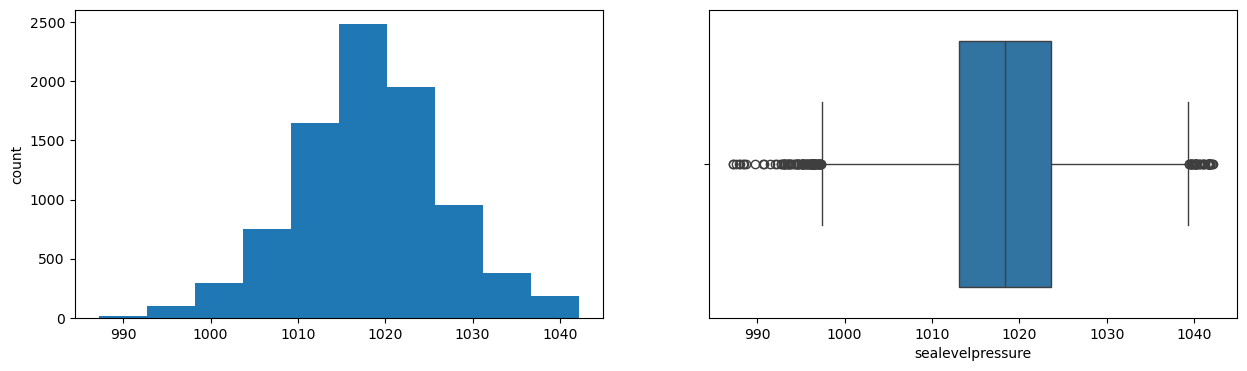

cloudcover
Skew : -0.76


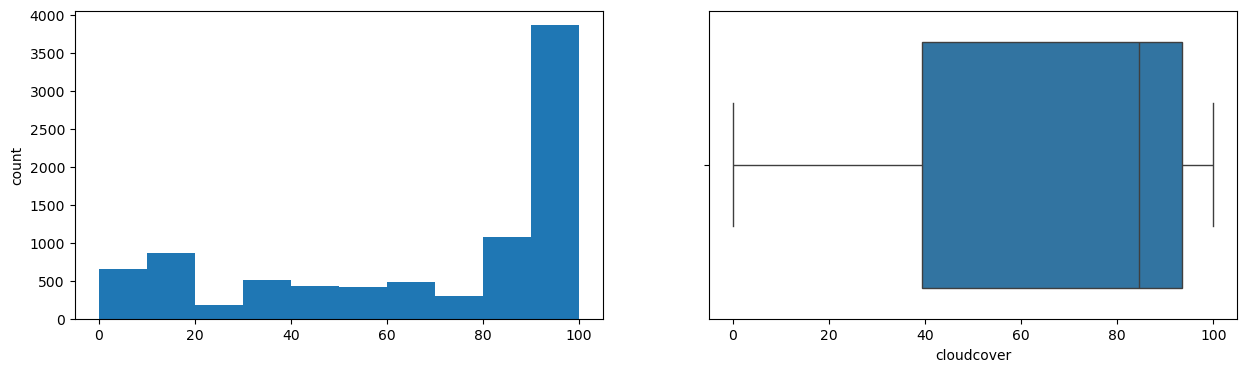

visibility
Skew : -0.58


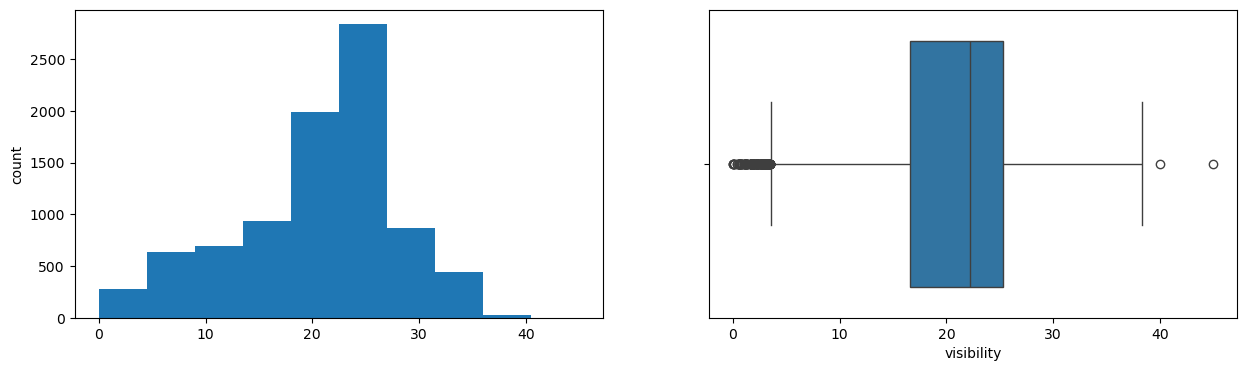

solarradiation
Skew : 3.19


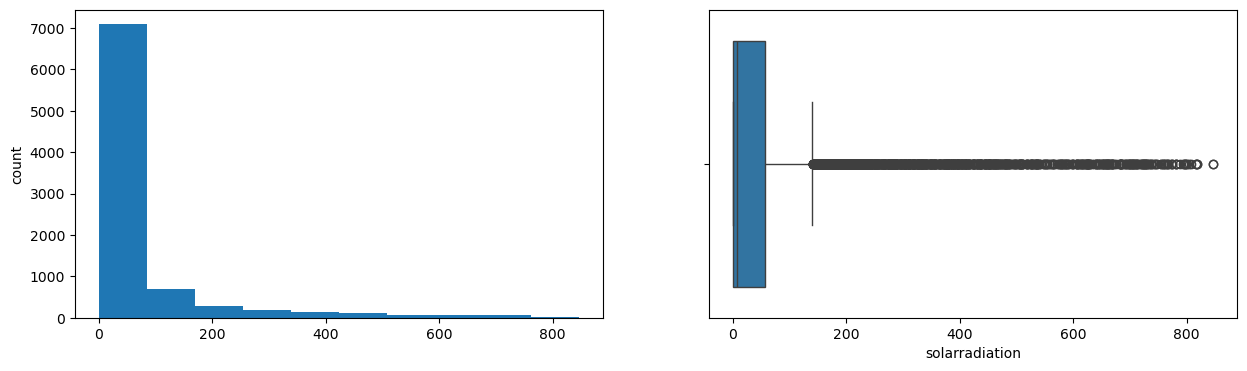

solarenergy
Skew : 3.18


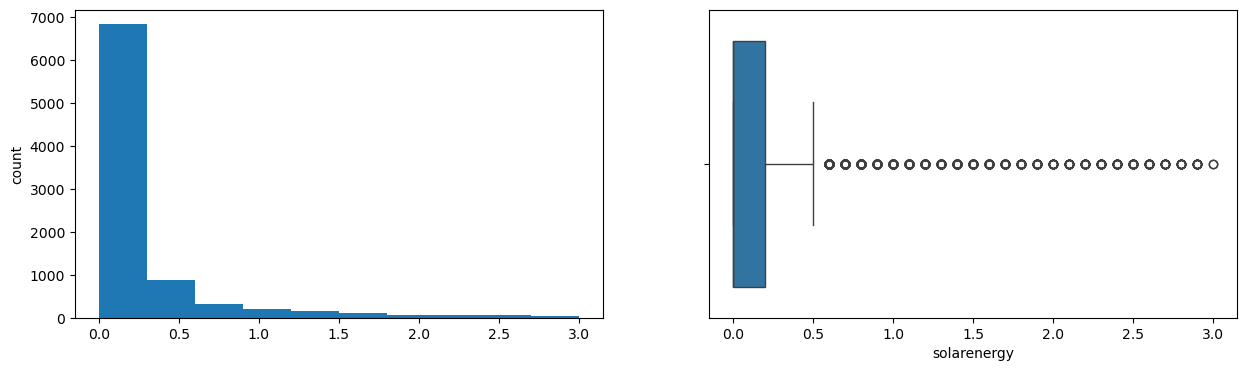

uvindex
Skew : 3.1


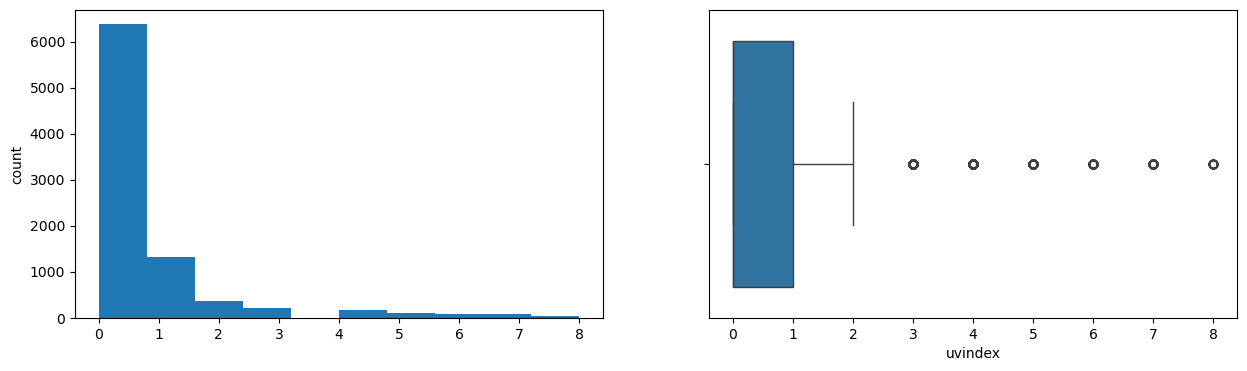

In [174]:
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

In [175]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category10_10
from bokeh.io import output_notebook

# Bokeh requires a ColumnDataSource for interactive plots
source = ColumnDataSource(df)

# Enable notebook output
output_notebook()

# Create a figure
p = figure(x_axis_type='datetime', title='Temperature over Time', x_axis_label='Datetime', y_axis_label='Temperature', outer_width=800,outer_height=400,)

# Plot temperature using a scatter plot with tooltips
scatter = p.scatter('datetime', 'temp', size=4, color=Category10_10[0], source=source)

# Add tooltips
hover = HoverTool()
hover.tooltips = [('Datetime', '@datetime{%F %T}'), ('Temperature', '@temp{0.2f} °C')]
hover.formatters = {'@datetime': 'datetime'}
p.add_tools(hover)

# Show the plot in the notebook
show(p, notebook_handle=True)


Loading BokehJS ...

In [176]:
le = LabelEncoder()
df['icon'] = le.fit_transform(df['icon'])

print(dict(zip(le.classes_, le.transform(le.classes_))))

{'clear-day': 0, 'clear-night': 1, 'cloudy': 2, 'fog': 3, 'partly-cloudy-day': 4, 'partly-cloudy-night': 5, 'rain': 6, 'snow': 7}


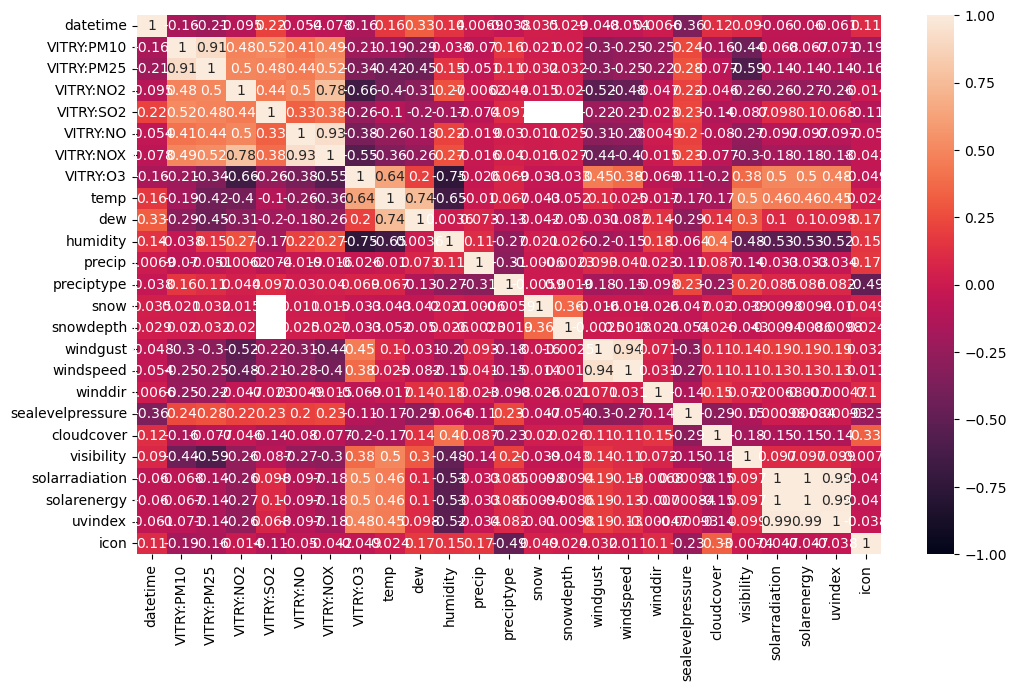

In [177]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

According to this correlation heatmap. We can see that some variables are not useful for our model. For instance windgust and windspeed are highly correlated which is logical. In the next steps we will remove those highly correlated variables.

In [178]:
df.columns

Index(['datetime', 'VITRY:PM10', 'VITRY:PM25', 'VITRY:NO2', 'VITRY:SO2',
       'VITRY:NO', 'VITRY:NOX', 'VITRY:O3', 'temp', 'dew', 'humidity',
       'precip', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'icon'],
      dtype='object')

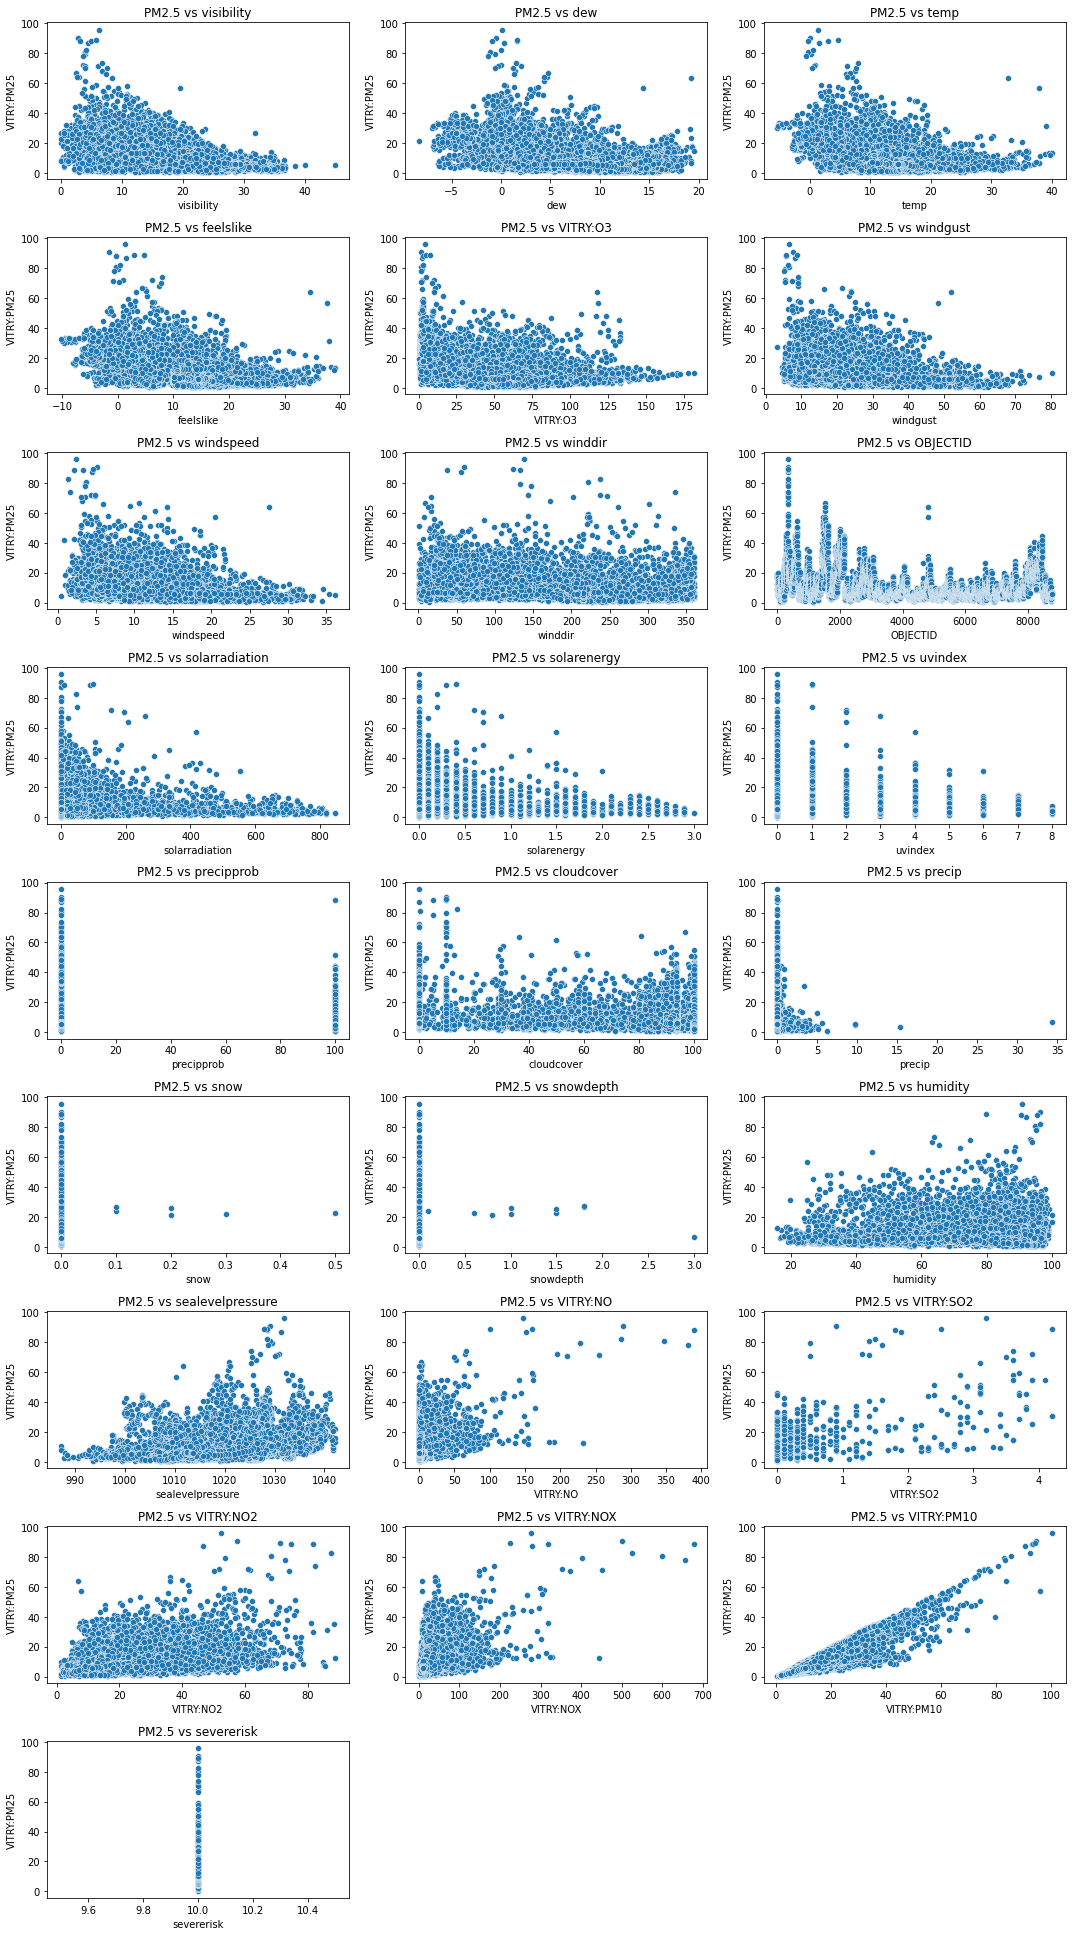

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
pollution_file_path = r'C:\Users\33766\Downloads\Vitry_meteo_2022\vitry_pollution\2022_VITRY.csv'
pollution_data = pd.read_csv(pollution_file_path, skiprows=lambda x: x in range(1, 6))
weather_data_folder = r'C:\Users\33766\Downloads\Vitry_meteo_2022\Vitry_meteo'
weather_files = [f for f in os.listdir(weather_data_folder) if f.startswith('vitry-sur-seine') and f.endswith('.csv')]
weather_data_list = []
for file in weather_files:
    file_path = os.path.join(weather_data_folder, file)
    temp_weather_data = pd.read_csv(file_path)
    weather_data_list.append(temp_weather_data)
combined_weather_data = pd.concat(weather_data_list, ignore_index=True)
pollution_data['datetime'] = pd.to_datetime(pollution_data['datetime'], utc=True)
combined_weather_data['datetime'] = pd.to_datetime(combined_weather_data['datetime'], utc=True)
combined_data = pd.merge(pollution_data, combined_weather_data, on='datetime', how='inner')

numeric_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = combined_data[numeric_cols]

correlation_with_pm25 = numeric_data.corr()['VITRY:PM25'].sort_values()

correlation_without_self = correlation_with_pm25.drop(labels=['VITRY:PM25'])

n_factors = len(correlation_without_self)
n_cols = 3  
n_rows = (n_factors + n_cols - 1) // n_cols  

plt.figure(figsize=(15, n_rows * 3))
for i, param in enumerate(correlation_without_self.index):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(data=combined_data, x=param, y='VITRY:PM25')
    plt.title(f'PM2.5 vs {param}')
plt.tight_layout()
plt.show()

# VI. Training and Evaluation

The training and evaluation stages are critical in the lifecycle of a machine learning project, where the model's theoretical underpinnings are put to the test against actual data. Let's detail each step in the context of your project, which involves using an LSTM network for predicting PM2.5 levels.

### Splitting the Data into Training and Testing Sets

Procedure: The dataset is split into a training set and a testing set. This segregation is crucial for unbiased evaluation of the model.
Implementation: In this project, this is done using train_test_split from Scikit-learn, with 75% of the data allocated for training and 25% for testing. Importantly, shuffle=False is set to preserve the time series order, crucial for a time-series forecasting problem like PM2.5 prediction.

### Training the Machine Learning Model

Model Architecture: A Sequential LSTM model is used, suitable for capturing time dependencies in the data.
Training Process: The model is trained on the training dataset. This involves feeding the model with the input features and corresponding target values, and iteratively adjusting the model weights to minimize prediction error.

Two strategies could have been made here since there are not that many null values on the PM25:
- Make a mean for the nan values based on the average PM25 concentration
- Put them at 0
- Filter the dataset to only keep not null values

In [179]:
dfpm25 = df[df['VITRY:PM25'].notnull()]

To have a lighter dataset with only useful data, we are dropping not used columns.

To take care of the nan values, we chose here to replace nan values with zeros.

The index has also been replaced with the datetime.

In [180]:
dfpm25 = dfpm25.drop(columns=["solarenergy","windgust","snow","VITRY:PM10","VITRY:NO2","VITRY:SO2","VITRY:NOX","VITRY:O3", "VITRY:NO"])

dfpm25.index = dfpm25['datetime'].values
dfpm25 = dfpm25.drop(columns= 'datetime')
dfpm25 = dfpm25.fillna(0)

In [181]:
dfpm25.head()

VITRY:PM25  temp  dew  humidity  precip  preciptype  \
2022-01-01 01:00:00        19.1  10.3  9.6     95.05   0.000           2   
2022-01-01 02:00:00        19.1  10.4  9.8     96.32   0.000           2   
2022-01-01 03:00:00        18.6  10.1  9.4     95.87   0.000           2   
2022-01-01 04:00:00        16.9   9.6  9.1     96.75   0.000           2   
2022-01-01 05:00:00        16.5   9.2  8.7     96.84   0.053           0   

                     snowdepth  windspeed  winddir  sealevelpressure  \
2022-01-01 01:00:00        0.0        6.0    159.0            1026.4   
2022-01-01 02:00:00        0.0        5.4    182.0            1026.5   
2022-01-01 03:00:00        0.0        6.9    166.0            1026.4   
2022-01-01 04:00:00        0.0        7.0    177.0            1026.2   
2022-01-01 05:00:00        0.0        7.0    153.0            1026.1   

                     cloudcover  visibility  solarradiation  uvindex  icon  
2022-01-01 01:00:00        68.2         4.1             0.0      0.0     5  
2022-01-01 02:00:00        92.9         5.2             0.0      0.0     2  
2022-01-01 03:00:00        49.6         4.4             0.0      0.0     5  
2022-01-01 04:00:00        38.1         4.1             0.0      0.0     5  
2022-01-01 05:00:00        55.8         3.0             0.0      0.0     6

In [182]:
print(tabulate(dfpm25.head(5),headers="keys",tablefmt="psql"))

+---------------------+--------------+--------+-------+------------+----------+--------------+-------------+-------------+-----------+--------------------+--------------+--------------+------------------+-----------+--------+
|                     |   VITRY:PM25 |   temp |   dew |   humidity |   precip |   preciptype |   snowdepth |   windspeed |   winddir |   sealevelpressure |   cloudcover |   visibility |   solarradiation |   uvindex |   icon |
|---------------------+--------------+--------+-------+------------+----------+--------------+-------------+-------------+-----------+--------------------+--------------+--------------+------------------+-----------+--------|
| 2022-01-01 01:00:00 |         19.1 |   10.3 |   9.6 |      95.05 |    0     |            2 |           0 |         6   |       159 |             1026.4 |         68.2 |          4.1 |                0 |         0 |      5 |
| 2022-01-01 02:00:00 |         19.1 |   10.4 |   9.8 |      96.32 |    0     |            2 |  

In [183]:
dfpm25.columns

Index(['VITRY:PM25', 'temp', 'dew', 'humidity', 'precip', 'preciptype',
       'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'uvindex', 'icon'],
      dtype='object')

### LSTM

In [184]:
print(tabulate(dfpm25.head(5), tablefmt = "psql", headers = "keys"))

+---------------------+--------------+--------+-------+------------+----------+--------------+-------------+-------------+-----------+--------------------+--------------+--------------+------------------+-----------+--------+
|                     |   VITRY:PM25 |   temp |   dew |   humidity |   precip |   preciptype |   snowdepth |   windspeed |   winddir |   sealevelpressure |   cloudcover |   visibility |   solarradiation |   uvindex |   icon |
|---------------------+--------------+--------+-------+------------+----------+--------------+-------------+-------------+-----------+--------------------+--------------+--------------+------------------+-----------+--------|
| 2022-01-01 01:00:00 |         19.1 |   10.3 |   9.6 |      95.05 |    0     |            2 |           0 |         6   |       159 |             1026.4 |         68.2 |          4.1 |                0 |         0 |      5 |
| 2022-01-01 02:00:00 |         19.1 |   10.4 |   9.8 |      96.32 |    0     |            2 |  

### Libraries imports

We will be using the Keras library, since it is the most user-friendly out of the 3 great ML libraries while being performant.

In [185]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Features and target selection

In [186]:
features = ['temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'winddir',
            'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'uvindex']
target = 'VITRY:PM25'

In [187]:
# Data preparation
dfpm25.sort_index()

# Standardize numerical features
scaler = StandardScaler()
dfpm25[features] = scaler.fit_transform(dfpm25[features])
dfpm25[target] = scaler.fit_transform(dfpm25[[target]])

# Split the data into training and testing sets
train_df, test_df = train_test_split(dfpm25, test_size=0.25, shuffle=False)

# Prepare X_train, y_train, X_test, y_test
X_train, y_train = train_df[features].values, train_df[target].values
X_test, y_test = test_df[features].values, test_df[target].values

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(14, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dense(28, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=25, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {mse}')

# Make predictions
predictions = model.predict(X_test)

# Reverse scaling for visualization
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/4
263/263 - 7s - loss: 0.8837 - val_loss: 0.3710 - 7s/epoch - 27ms/step
Epoch 2/4
263/263 - 1s - loss: 0.6228 - val_loss: 0.3271 - 951ms/epoch - 4ms/step
Epoch 3/4
263/263 - 1s - loss: 0.4985 - val_loss: 0.3759 - 953ms/epoch - 4ms/step
Epoch 4/4
263/263 - 1s - loss: 0.4403 - val_loss: 0.4148 - 939ms/epoch - 4ms/step
69/69 [==============================] - 0s 2ms/step - loss: 0.4148
Mean Squared Error on Test Set: 0.4148028790950775
69/69 [==============================] - 1s 2ms/step


In [188]:
train_df.shape

(6555, 15)

## Evaluating Model Performance

Metrics: Model performance is evaluated using the Mean Squared Error (MSE) metric, a standard choice for regression problems.  
Evaluation: 

In [189]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling for predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared (R2) score
r2 = r2_score(y_test_original, y_pred)
print(f'R-squared (R2) Score: {r2}')


27/69 [==========>...................] - ETA: 0s69/69 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 13410.343892303852
R-squared (R2) Score: -1.7705549546202555


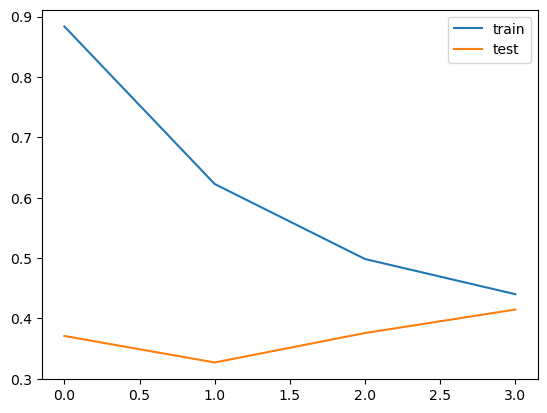

In [190]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [191]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
import pandas as pd

# Assuming 'predictions' and 'y_test' are your predicted and actual values
df_plot = pd.DataFrame({'DateTime': test_df.index, 'Predicted_PM25': predictions.flatten(), 'Actual_PM25': y_test.flatten()})

# Create a ColumnDataSource
source = ColumnDataSource(df_plot)

# Create a Bokeh figure
p = figure(title='Comparison of Predicted and Actual PM25 Values', x_axis_label='DateTime', y_axis_label='PM25 Values', width=800, height=400, x_axis_type='datetime')

# Plot the dots for Predicted PM25
p.circle(x='DateTime', y='Predicted_PM25', size=2, legend_label='Predicted PM25', color='blue', source=source)

# Plot the dots for Actual PM25
p.circle(x='DateTime', y='Actual_PM25', size=2, legend_label='Actual PM25', color='green', source=source)

# Add legend
p.legend.location = 'top_left'

# Show the plot
show(p, output_notebook = True)


### Randomforest
We also used the random forest model to build a predictive model and wanted to compare the two models.

<Figure size 1500x600 with 0 Axes>

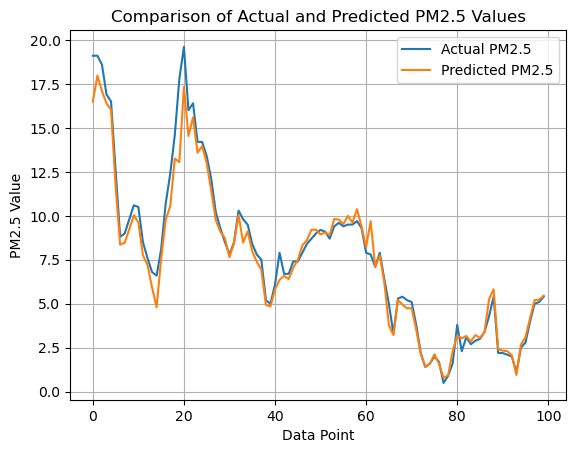

In [192]:
# Handling missing values and selecting features 
from sklearn.ensemble import RandomForestRegressor

features = ['temp', 'humidity', 'precip', 'windspeed', 'cloudcover', 'uvindex', 
            'VITRY:PM10', 'VITRY:NO2', 'VITRY:SO2', 'VITRY:NO', 'VITRY:NOX', 'VITRY:O3']
target = 'VITRY:PM25'
df_rf = df.copy()
df_rf.fillna(df_rf.mean(), inplace=True)
X = df_rf[features]
y = df_rf[target]

# Model Building and Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and Graph Plotting
y_all_pred = model.predict(X)
comparison_df = pd.DataFrame({'Actual PM2.5': y, 'Predicted PM2.5': y_all_pred})
plt.figure(figsize=(15, 6))
comparison_df.head(100).plot(kind='line')
plt.title('Comparison of Actual and Predicted PM2.5 Values')
plt.xlabel('Data Point')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse,r2
#(3.4010357714968507, 0.9616650271230045)

(3.4010357714968507, 0.9616650271230045)

### Challenges During Training and Evaluation

Since RNN and more specifically LSTM RNN are relatively recent for us the greatest challenge was to get accustomed to it.

### More general challanges and room for improvement

Since air pollution is a complex system with more dependencies that only one place. Adding several locations could be a great room for improvement, because air pollution can be localized and moved from one place to another with the air direction.

We also had 5 years of pm25 concentrations at Vitry, a training and testing on 5 years of weather data could lead to a more robust model (for instance train on one entire year and test on another one).

# VIII. Conclusion


As an introduction to Air Pollution, our results from our models are encouraging. 

Predicting PM25 concentration with weather data is possible.
PM10,NOX,NO2,SO2,NO.These signatures are primarily concentrations of different pollutants relevant to air quality, suggesting there may be interactions or common sources between these pollutants that influence PM2.5 levels.

# IX. Future Work

First since we also have these datas, predicting other pollutants is also possible, however not all of them may have a correlation with weather data.

An in-depth study of the subject in general is mandatory in this kind of studies, having a global overview of air pollution could have helped us to focus on factors that are not used in our models (factories, car trafic).

As said earlier, a great room for improvement could have been to add spatial dependencies which are not used here. Vitry is not isolated, depending on the air movements air from more polluted areas can go to Vitry and have an effect on the local air pollution situation.


# X. References


List all sources, datasets, libraries, and frameworks used in the project.

Air-quality data : https://data-airparif-asso.opendata.arcgis.com/

Historical weather data : https://www.visualcrossing.com/weather/weather-data-services

Libraries : 
-   Tabulate
-   Numpy
-   Pandas
-   Keras
-   Bokeh
-   Matplotlib
-   Sklearn


# XI. Appendices